# <a id='toc1_'></a>[Evaluation of multi-omics GRN inference methods](#toc0_)
## <a id='toc1_1_'></a>[Topological analysis of the inferred GRNs](#toc0_)
### <a id='toc1_1_1_'></a>[by Jalil Nourisa](#toc0_)

# Imports

In [1]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
import tqdm
import scipy
%matplotlib inline
work_dir = '../output'
kaggle_data_dir = '../input/kaggle/input'
os.makedirs(f'{work_dir}', exist_ok=True)
os.makedirs(f'{work_dir}/missing_genes', exist_ok=True)


# Data of the open problems competition

In [2]:
multiome_var_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_var_meta.csv')
# multiome_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_train.parquet')
multiome_obs_meta = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/multiome_obs_meta.csv')

## Competition training data

In [149]:
# main dataset
de_train = pd.read_parquet(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/de_train.parquet')
data_df = de_train.iloc[:,5:]
data_df['cell_type'] = de_train['cell_type']
data_df['sm_name'] = de_train['sm_name']
data_df = data_df.set_index(['cell_type','sm_name'])
data = data_df.values
data_df.shape

(614, 18211)

In [8]:
id_map = pd.read_csv(f'{kaggle_data_dir}/open-problems-single-cell-perturbations/id_map.csv', index_col=0)

### Apply filtering

In [154]:
# filter mask
filter_mask_de = pd.read_csv(f'../input/filter_mask_de.csv', index_col=0)
filter_mask_de['cell_type'] = de_train['cell_type']
filter_mask_de['sm_name'] = de_train['sm_name']
filter_mask_de = filter_mask_de.set_index(['cell_type','sm_name'])

In [155]:
data_df_filter = data_df[filter_mask_de]
data_df_filter.shape

(614, 18211)

### Second filtering

In [156]:
# only those genes with more than= 10 samples
gene_t_filter = filter_mask_de.sum()>=10
# remove those samples with less than 2000 genes
sample_t_filter = filter_mask_de.sum(axis=1)>=2000

In [157]:
data_df_filter = data_df_filter.loc[sample_t_filter, gene_t_filter]
data_df_filter.shape

(547, 18147)

In [25]:
## what portion of data is missing after filter +
data_df_filter.isna().values.ravel().sum()/(data_df_filter.shape[0]*data_df_filter.shape[1])

0.2732782822065865

### Impute missings
This will be only used for encoding outputs

In [158]:
# mask that shows the real values
real_values_mask = ~data_df_filter.isna()

In [2]:
if False:
    from sklearn.impute import KNNImputer
    # Creating the imputer object. You can adjust 'n_neighbors' based on your dataset size and characteristics
    imputer = KNNImputer(n_neighbors=10)
    # Imputing the missing values
    data_df_filter_imputed = pd.DataFrame(imputer.fit_transform(data_df_filter), columns=data_df_filter.columns, index=data_df_filter.index)
    data_df_filter_imputed.to_csv('../input/data_df_filter_imputed.csv')
else:
    data_df_filter_imputed = pd.read_csv('../input/data_df_filter_imputed.csv')
    data_df_filter_imputed.set_index(['cell_type', 'sm_name'], inplace=True)

In [4]:
df_main = data_df_filter_imputed
gene_names_de = df_main.columns

### Missing genes comaring scRNA-seq to de_train
Only 15580 genes out of 18211 genes shared between these two datasets, missing 2631 genes.

In [33]:
gene_names = multiome_var_meta[multiome_var_meta.feature_type=='Gene Expression'].location.unique()
shared_genes = np.intersect1d(gene_names, gene_names_de)
missing_genes = np.setdiff1d(gene_names_de, shared_genes)
print(f'Genes in scRNA {len(gene_names)}, in de_train: {len(gene_names_de)}, shared : {len(shared_genes)}, missing: {len(missing_genes)}')

Genes in scRNA 22787, in de_train: 18211, shared : 15580, missing: 2631


## Biomart annotation of genes

In [11]:
import pybiomart as pbm
species = 'hsapiens'
host = "http://sep2019.archive.ensembl.org/"   # best one
dataset = pbm.Dataset(name=species+'_gene_ensembl',  host=host)
annot = dataset.query(attributes=['chromosome_name', 'start_position', 'end_position', 'external_gene_name', 'transcript_biotype'])

annot.columns = ['chr', 'start', 'end', 'gene', 'transcript_type']
annot['width'] = annot.end-annot.start

filter = annot['chr'].str.contains('CHR|GL|JH|MT|KI27')
annot = annot[~filter].reset_index(drop=True)
# change in names
annot.chr = annot.chr.apply(lambda x:f'chr{x}')
annot.drop_duplicates(inplace=True)

In [12]:
gene_names_annot =  annot[annot.gene.isin(gene_names_de)].reset_index(drop=True).gene.unique()
missing_genes_annot = np.setdiff1d(gene_names_de, gene_names_annot)
print('number of gene in de_train annotated ', len(gene_names_annot), 
      '/', len(gene_names_de), f' with missing {len(missing_genes_annot)}')

number of gene in de_train annotated  17626 / 18147  with missing 521


### Transcript type of genes
Around half of the given genes are protein encoders. This shows that non-protein coding genes might play a significant role in the gene regulation.

In [13]:
annot[annot.gene.isin(gene_names_de)].reset_index(drop=True).transcript_type.value_counts().head()

transcript_type
protein_coding             12833
lncRNA                     11062
retained_intron             7613
nonsense_mediated_decay     5601
processed_pseudogene         799
Name: count, dtype: int64

## Significance test using ks_1samp

In [73]:
def calculate_p_values(genes, df):
    '''
    We conduct a 1-sample Kolmogorov-Smirnov (KS) test to detemine p-values for each given gene versus a uniform set.
    Taken from Antoine Passiemier.
    '''
    p_values = []
    for k, gene in tqdm.tqdm(enumerate(genes)):  # Perform test for each gene
        v = df.iloc[:, k].values
        v_valid = v[~np.isnan(v)]
        if len(v_valid)<10:
            raise ValueError('shouldnt be')
            p_value = np.nan
        else:
            v_valid = 10 ** (-np.abs(v_valid))  # Transform DE values to p-values (assumed to be uniformly-distributed)
            res = scipy.stats.mstats.ks_1samp(v_valid, scipy.stats.uniform.cdf)  # Kolmogorov-Smirnov test
            p_value = res[1]
        p_values.append(p_value)
    p_values = np.asarray(p_values)
    return p_values

# de_p_values = calculate_p_values(gene_names_de, data_df_filter)
# de_p_values_imput = calculate_p_values(gene_names_de, data_df_filter_imputed)

In [17]:
print('number of genes with insufficient samples for p values test: ', np.isnan(de_p_values).sum())
de_p_values_valid = de_p_values[~np.isnan(de_p_values)]
print('portion of sig genes to all genes: ', (de_p_values_valid<0.001).sum()/len(de_p_values_valid))

number of genes with insufficient samples for p values test:  0
portion of sig genes to all genes:  0.19253871163277678


In [37]:
print('number of genes with insufficient samples for p values test (imput data): ', np.isnan(de_p_values_imput).sum())
de_p_values_valid_imput = de_p_values_imput[~np.isnan(de_p_values_imput)]
print('portion of sig genes to all genes (imput data): ', (de_p_values_valid_imput<0.001).sum()/len(de_p_values_valid_imput))

number of genes with insufficient samples for p values test (imput data):  0
portion of sig genes to all genes (imput data):  0.35735934314211715


## Housekeeping genes versus all genes


In [18]:

def plot_sig_vs_all_genes(target_p_values, name='Missing genes'):
    '''
    Plot the distribution of log p-values obtained from ks_1samp test for a set of given genes versus de_train genes.
    '''
    significance_threshold = 0.001/len(gene_names_de)  # Arbitrary cutoff
    plt.figure(figsize=(5, 5))
    ax = plt.subplot(1, 1, 1)
    plt.hist(np.log10(de_p_values), bins=1000, density=True, alpha=0.55, label='All genes', color='navy')
    plt.hist(np.log10(target_p_values), bins=1000, density=True, alpha=0.55, label=name, color='goldenrod')
    plt.axvline(x=np.log10(significance_threshold), linestyle='--', color='black', label='0.001 threshold (adjusted)')
    plt.xlabel('P-value (log10) from Kolmogorov-Smirnov test')
    plt.ylabel('Number of genes')
    ax.spines[['right', 'top']].set_visible(False)
    plt.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='grey')
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
    plt.xlim([-50, 0])
    plt.show()  


In [19]:
df = pd.read_csv('https://www.tau.ac.il/~elieis/HKG/HK_genes.txt', sep=' ', header=None)
housekeeping_genes = df.loc[:, 0]  # Gene names
housekeeping_genes_filter = np.isin(gene_names_de, housekeeping_genes)
print(f'Number of housekeeping genes: {len(housekeeping_genes)}')

Number of housekeeping genes: 3804


In [20]:
def evaluate_missingness(genes):
    # genes 
    print('number of given genes: ', len(genes))
    genes_filter = np.isin(gene_names_de, genes)
    de_p_values_genes = de_p_values[genes_filter]
    de_p_values_genes_valid = de_p_values_genes[~np.isnan(de_p_values_genes)]
    print('sig genes/all sig genes: ', (de_p_values_genes_valid<0.001).sum()/(de_p_values_valid<0.001).sum())

    # missing genes
    print('\n')
    missing_genes = gene_names_de[~genes_filter]
    print('number of missing genes: ', len(missing_genes))
    de_p_values_missing = de_p_values[~genes_filter]
    de_p_values_missing_valid = de_p_values_missing[~np.isnan(de_p_values_missing)]
    print('missing sig genes/all sig genes: ', (de_p_values_missing_valid<0.001).sum()/(de_p_values_valid<0.001).sum())

    
    print('missing sig genes/missing genes: ',(de_p_values_missing_valid<0.001).sum()/len(de_p_values_missing_valid))

In [21]:
evaluate_missingness(housekeeping_genes)
# plot_sig_vs_all_genes(de_p_values_hg_valid, name='House keeping genes')

number of given genes:  3804
sig genes/all sig genes:  0.11705781339439038


number of missing genes:  14629
missing sig genes/all sig genes:  0.8829421866056096
missing sig genes/missing genes:  0.21088249367694306


# Predictive model 

In [215]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
import decoupler as dc
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold

random_state = 32

class model_encoder:
    def __init__(self, df_main, n_components=35, shares={
                                        'sm_name':{'de_x':35},
                                        'cell_type': {'de_x':6}
                                        },
                                        te_params = dict(min_samples_leaf=20, smoothing=100),
                                        grn_model=None, 
                                        specific=False #specific GRN for each celltype
                                        ):  
        self.specific = specific
        # target df to encode
        self.df_main = df_main
        self.grn_model = grn_model
        # regressor
        self.emb_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
        # reducer
        self.reducer = TruncatedSVD(n_components=n_components, n_iter=12, random_state=random_state)
        self.Y = self.reducer.fit_transform(df_main)
        # encoder 
        self.enc = ce.TargetEncoder(**te_params) #[0, 0.05, 0.5, 0.1,0.9,10]
        # encode data
        var_x_name = list(shares['sm_name'].keys())[0]
        n_components = shares['sm_name'][var_x_name]
        y_sm_name = self.create_feature_space(self.df_main, var_x=var_x_name, n=n_components)
        
        # cell type
        var_x_name = list(shares['cell_type'].keys())[0]
        n_components = shares['cell_type'][var_x_name]
        y_cell_type = self.create_feature_space(self.df_main, var_x=var_x_name, n=n_components)
        # the order is important
        self.emb_data = {'sm_name':y_sm_name, 'cell_type': y_cell_type}
        self.determine_X()
        print(self.X.shape, self.X_submit.shape)

    def determine_X(self):
        for i, (name, y) in enumerate(self.emb_data.items()):
            for i_target in tqdm.tqdm(range(y.shape[1])):
                if i_target == 0:
                    X_encoded = self.enc.fit_transform(self.df_main.reset_index()[name], y[:,i_target])
                    X_submit_encoded = self.enc.transform(id_map.reset_index()[name])
                else:
                    X_encoded_tmp = self.enc.fit_transform(self.df_main.reset_index()[name], y[:,i_target])
                    X_encoded = np.concatenate( [X_encoded, X_encoded_tmp], axis = 1)
                    X_encoded_tmp = self.enc.transform(id_map.reset_index()[name])
                    X_submit_encoded = np.concatenate([X_submit_encoded, X_encoded_tmp], axis = 1)
            if i == 0:
                X = X_encoded
                X_submit = X_submit_encoded
            else:
                X = np.concatenate([X, X_encoded], axis = 1)
                X_submit = np.concatenate([X_submit, X_submit_encoded], axis = 1)

        self.X = X
        self.X_submit = X_submit
    def create_feature_space(self, df_to_encode, var_x='sm_name', n=35):
        
        if var_x == 'de_x':
            return TruncatedSVD(n_components=n, n_iter=12, random_state=random_state).fit_transform(df_to_encode.values)

        elif var_x == 'tf_x':
            df_main_c = df_to_encode.copy()
            df_main_c.index = df_main_c.index.map(lambda x: '@'.join(map(str, x))) # this is needed for enrichment analyisis
            net = self.grn_model
            if self.specific:
                pass
                
            else:
                tf_act, p_values = dc.run_ulm(
                    df_main_c,
                    net,
                    source='source',
                    target='target',
                    weight='weight',
                    verbose=True
                    )

            tf_x = TruncatedSVD(n_components=n, n_iter=12, random_state=random_state).fit_transform(tf_act)
            return tf_x
        raise ValueError('define feature space')
    def validate(self, mask_tr, mask_va):
        # print(mask_tr)
        X_tr, Y_tr = self.X[mask_tr,:], self.Y[mask_tr,:]
        X_va = self.X[mask_va,:]
        self.emb_model.fit(X_tr, Y_tr)
        return self.reducer.inverse_transform(self.emb_model.predict(X_va))

In [131]:
from decoupler.pre import extract, match, rename_net, get_net_mat, filt_min_n
from decoupler.method_ulm import t_val
from scipy.stats import t

def get_net_mat_multiple(nets):
    """
    Transforms a given network to a regulatory adjacency matrix (targets x sources).

    Parameters
    ----------
    nets : dict[int, DataFrame]
        Network in long format.

    Returns
    -------
    sources : ndarray
        Array of source names.
    targets : ndarray
        Array of target names.
    X : ndarray
        Array of interactions bewteen sources and targets (target x source).
    """
    X_
    # Pivot df to a wider format
    for i, net in nets.items():
        X = net.pivot(columns='source', index='target', values='weight')
        X[np.isnan(X)] = 0

    # Store node names and weights
    sources = X.columns.values
    targets = X.index.values
    X = X.values
    return sources.astype('U'), targets.astype('U'), X.astype(np.float32)

def run_ulm(mat, net, source='source', target='target', weight='weight', batch_size=10000,
            min_n=5, verbose=False, use_raw=True
            , multiple_grn:dict[int,pd.DataFrame]=False, indices:list[int]=None
            ):
    # Extract sparse matrix and array of genes
    readouts, sample_names, feature_names = extract(mat, use_raw=use_raw, verbose=verbose)
    # Transform net
    net = rename_net(net, source=source, target=target, weight=weight)
    net = filt_min_n(feature_names, net, min_n=min_n)
    print(net.shape)
    if multiple_grn:
        pass
    else:
        sources, targets, net = get_net_mat(net)
        net = match(feature_names, targets, net)
        if verbose:
            print('Running ulm on mat with {0} samples and {1} targets for {2} sources.'.format(readouts.shape[0], len(feature_names), net.shape[1]))
    # Run ULM
    estimate, pvals = ulm(readouts, net, batch_size=batch_size, verbose=verbose)
    # Transform to df
    estimate = pd.DataFrame(estimate, index=sample_names, columns=sources)
    estimate.name = 'ulm_estimate'
    pvals = pd.DataFrame(pvals, index=sample_names, columns=sources)
    pvals.name = 'ulm_pvals'
    return estimate, pvals
def mat_cov(net, b):
    multi = np.dot(b.T - b.mean(), net - net.mean(axis=0))
    return  multi/ (b.shape[0]-1)

def mat_cor(net, b):
    cov = mat_cov(net, b)
    ssd = np.std(net, axis=0, ddof=1) * np.std(b, axis=0, ddof=1).reshape(-1, 1)
    return cov / ssd

def ulm(mat, net, batch_size=10000, verbose=False):
    
    # Get dims
    n_features, n_fsets = net.shape # genes*TFs
    df = n_features - 2 
    r = mat_cor(net, mat.T)
    # Compute t-value
    es = t_val(r, df)
    # Compute p-value
    pv = t.sf(abs(es), df) * 2
    return es, pv

df_main_c = df_main.copy()
df_main_c.index = df_main_c.index.map(lambda x: '@'.join(map(str, x))) # this is needed for enrichment analyisis
tf_act, p_values = run_ulm(
    df_main_c,
    figr_grn,
    source='source',
    target='target',
    weight='weight',
    verbose=True
    )

(18682, 3)
Running ulm on mat with 547 samples and 18147 targets for 727 sources.


# Cross-validation

In [174]:
import pandas as pd
import numpy as np
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

sig_mask = 10 ** (-np.abs(df_main.values)) < 0.05
df_main_sig = df_main[real_values_mask*sig_mask]
values = df_main_sig.values.ravel()

print('portion of sig pvalues in df_main: ', values[~np.isnan(values)].shape/df_main_sig.size)

portion of sig pvalues in df_main:  [0.05971142]


## CV scheme

In [287]:
sm_names = df_main.index.get_level_values('sm_name')
# define groups 
unique_sm_names = sm_names.unique()
if False:
    np.random.seed(32)
    group_assignments = np.random.randint(1, 6, size=len(unique_sm_names))
    group_dict = dict(zip(unique_sm_names, group_assignments))
else: # one group for each sm_name
    group_assignments = range(len(unique_sm_names))
    group_dict = dict(zip(unique_sm_names, group_assignments))
groups = sm_names.map(group_dict)
# cv scheme
def compute_cv(model, df_main, genes_mask=None):
    unique_groups = sorted(np.unique(groups))
    mrrmse_list = []
    for group in tqdm.tqdm(unique_groups):
        mask_va = groups==group
        mask_tr = groups!=group
        y_true = df_main[mask_va]
        y_pred = pd.DataFrame(model.validate(mask_tr, mask_va), index=y_true.index, columns=y_true.columns)
        # filter for the case that there are mask on gene
        # evaluate only those that are sig and also non imputed
        if True: 
            real_values = real_values_mask[mask_va] 
            sig_values = sig_mask[mask_va]
            group_mask = real_values*sig_values # take into account both filters
            
            if genes_mask is not None:
                group_mask_shortlisted = group_mask.loc[:, genes_mask]
                # print(group_mask.shape, genes_mask.shape, group_mask_shortlisted.shape)
                y_pred = y_pred[group_mask_shortlisted]
                y_true = y_true[group_mask_shortlisted]
            else:
                y_true = y_true[group_mask]
                y_pred = y_pred[group_mask]
            y_true = y_true.values.ravel()
            y_pred = y_pred.values.ravel()

            y_true = y_true[~np.isnan(y_true)]
            y_pred = y_pred[~np.isnan(y_pred)]

            if len(y_true)<100:
                raise ValueError('problem here')

        mrrmse = mean_absolute_error(y_pred, y_true)
        # mrrmse = np.sqrt(np.square(y_true - y_pred).mean()).mean();  

        mrrmse_list.append(mrrmse)
    return np.mean(mrrmse_list)
# compute_cv(model_figr, df_main_short, genes_mask)

## GRNs 

In [ ]:
collectRI = pd.read_csv('../../op_singlecell/input/collectri.csv')
# only retaining signs in FigR
figr_grn_art = figr_grn.copy()
weights = figr_grn_art.weight
weights = [1 if weight>1 else -1 for weight in weights]
figr_grn_art.weight = weights

## All genes

In [ ]:
model_figr = model_encoder(df_main, grn_model=figr_grn_art, shares={
                                        'sm_name':{'tf_x':35},
                                        'cell_type': {'tf_x':6}
                                        })
compute_cv(model_figr)

In [ ]:
baseline: 1.639
scenic: 1.73
collectRI: 1.75
figR: 1.6555156258877635, FigR_binarized = 1.641463193349164
CO_dump: 1.7248554603875579


## Genes subest

In [290]:
grn_model = scenicplus_grn_direct

genes_mask = df_main.columns.isin(grn_model.target) # mask on genes
df_main_short = df_main.loc[:, genes_mask] # subset training data for given genes

# construct the model
model_grn = model_encoder(df_main_short, grn_model=grn_model, shares={'sm_name':{'tf_x':33},
                                                                    'cell_type': {'tf_x':6}
                                                                    }) 
model_baseline = model_encoder(df_main_short, shares={'sm_name':{'de_x':35},
                                                        'cell_type': {'de_x':6}
                                                        }) 
# run cv
print('GRN: ', compute_cv(model_grn, df_main_short, genes_mask))
print('baseline: ', compute_cv(model_baseline, df_main_short, genes_mask))

Running ulm on mat with 547 samples and 7279 targets for 33 sources.
Running ulm on mat with 547 samples and 7279 targets for 33 sources.


100%|██████████| 6/6 [00:00<00:00, 80.89it/s]


(547, 39) (255, 39)


100%|██████████| 6/6 [00:00<00:00, 89.99it/s]


(547, 41) (255, 41)


100%|██████████| 130/130 [03:24<00:00,  1.58s/it]


GRN:  1.8905451278438477


100%|██████████| 130/130 [03:21<00:00,  1.55s/it]

baseline:  1.7029762011983405


In [ ]:
scenic: 1.8905451278438477, baseline=1.7029762011983405 
collectRI: -
figR: -, 
FigR_binarized = 1.6689704695433527, baseline: 1.6622253572450494
CO_dump: -

# Process results of GRN inference
- Stats of regulatory elements 

In [ ]:
postprocess_dir = '../output/postprocess'
os.makedirs(postprocess_dir, exist_ok=True)

## FigR

### GRN

In [32]:
figr_grn = pd.read_csv('../output/FigR/figR.d_all.csv', index_col=0)
# filter based on enrichment 
figr_grn = figr_grn[figr_grn['Enrichment.P']<0.05]
# filter bsaed on correlatoon
figr_grn = figr_grn[figr_grn['Corr.P']<0.05]
# filter thoes that are 0 score 
figr_grn = figr_grn[figr_grn.Score!=0]
# subset columns
figr_grn = figr_grn[['Motif', 'DORC', 'Score']]
figr_grn = figr_grn.reset_index(drop=True)
figr_grn.columns = ['source', 'target','weight']

In [33]:
print('number of TFs ', figr_grn.source.unique().shape[0], ' gene ', figr_grn.target.unique().shape[0])

number of TFs  818  gene  7134


In [30]:
evaluate_missingness(figr_grn.target.unique())

NameError: name 'evaluate_missingness' is not defined

### GRN for DORCs (10 peaks)

In [58]:
figr_net = pd.read_csv('../output/FigR/figR.d.csv', index_col=0)
# filter based on enrichment 
figr_net_f = figr_net[figr_net['Enrichment.P']<0.05]
# filter bsaed on correlatoon
figr_net_f_f = figr_net_f[figr_net_f['Corr.P']<0.05]
figr_net_f_f = figr_net_f_f[figr_net_f_f.Score==0]
print('number of TFs ', figr_net_f_f.Motif.unique().shape[0], ' gene ', figr_net_f_f.DORC.unique().shape[0])

number of TFs  39  gene  71


### Peak-gene connections 

In [ ]:
# load peak-gene association after filtering for significant
peak_gene_figr = pd.read_csv('../output/FigR/cisCorr.filt.csv', index_col=0)
peak_gene_figr_n = peak_gene_figr.groupby('Gene').apply(lambda df:df['PeakRanges'].shape[0])
np.max(peak_gene_figr_n.values), np.median(peak_gene_figr_n.values)

(24, 1.0)

In [ ]:
print('In the peak-gene associations: number of  CIS ', peak_gene_figr.PeakRanges.unique().shape[0], ', gene ', peak_gene_figr.Gene.unique().shape[0])

In the peak-gene associations: number of  CIS  17179  gene  8244


In [ ]:
print('number of DORC genes ', (peak_gene_figr_n.values >= 5).sum())

number of DORC genes  661


### Predictive performance 

In [ ]:
model_figr = model_encoder(df_main, grn_model=figr_grn, shares={
                                        'sm_name':{'tf_x':35},
                                        'cell_type': {'tf_x':6}
                                        })
compute_cv(model_figr)

## CellOracle

### Peak-gene 

In [ ]:
peak_gene_co = pd.read_csv('../output/scenicplus/peak_gene.csv', index_col=0)
peak_gene_co_n = peak_gene_co.groupby('gene_short_name').apply(lambda df:df['peak_id'].shape[0])
np.max(peak_gene_co_n.values), np.median(peak_gene_co_n.values)

In [ ]:
print('number of DORC genes ', (peak_gene_co_n.values > 10).sum())

In [ ]:
# print('number of TFs ', scenicplus.TF.unique().shape[0], ' CIS ', scenicplus.Region.unique().shape[0], ' gene ', scenicplus.Gene.unique().shape[0])
print('number of DORC genes with t of 10 ', (peak_gene_co_n.values > 10).sum())
print('number of DORC genes with t of 5 ', (peak_gene_co_n.values > 5).sum())

number of DORC genes with t of 10  0
number of DORC genes with t of 5  4


### Inferred GRN

In [85]:
co_grn = pd.read_csv('../output/celloracle/merged_grn.csv', index_col=0)

In [231]:
co_grn_short = co_grn[['source','target', 'weight_B cells']]
co_grn_short.columns = ['source','target', 'weight']

In [80]:
print(f'TFs : {co_grn.source.unique().shape} ,  genes : {co_grn.target.unique().shape}')

TFs : (560,) ,  genes : (13271,)


In [113]:
evaluate_missingness(co_grn.target.unique())

number of given genes:  13806
sig genes/all sig genes:  0.6250715512306811


number of missing genes:  6031
missing sig genes/all sig genes:  0.37492844876931886
missing sig genes/missing genes:  0.21884396926161043


### Predictive performance

In [81]:
model_co = model_encoder(df_main, grn_model=co_grn, shares={
                                        'sm_name':{'tf_x':35},
                                        'cell_type': {'tf_x':6}
                                        }, specific=True)
compute_cv(model_co)

ulm is used


AssertionError: Column name "weight" not found in net. Please specify a valid column.Alternatively, set to None if no weights are available.

## Scenic+

In [66]:
scenicplus_grn =  pd.read_csv(f'../output/scenicplus/scenicplus.csv', index_col=0)
peak_gene_scenicplus_n = scenicplus_grn.groupby('target').apply(lambda df:df['region'].shape[0])
np.max(peak_gene_scenicplus_n.values), np.median(peak_gene_scenicplus_n.values)

(96, 7.0)

In [72]:
scenicplus_grn.drop_duplicates().shape

(89002, 4)

In [67]:
print('number of TFs ', scenicplus_grn.source.unique().shape[0], ' CIS ', scenicplus_grn.region.unique().shape[0], ' gene ', scenicplus_grn.target.unique().shape[0])
print('number of DORC genes with t of 10 ', (peak_gene_scenicplus_n.values > 10).sum())
print('number of DORC genes with t of 5 ', (peak_gene_scenicplus_n.values > 5).sum())

number of TFs  33  CIS  25082  gene  7461
number of DORC genes with t of 10  2949
number of DORC genes with t of 5  4288


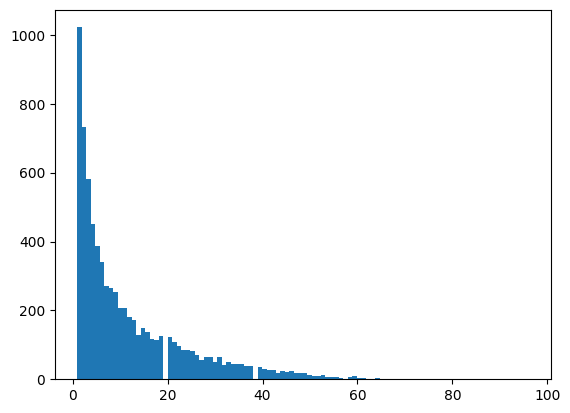

In [68]:
aa = plt.hist(peak_gene_scenicplus_n.values, bins=100)


In [116]:
evaluate_missingness(scenicplus_grn.target.unique())

number of given genes:  7461
sig genes/all sig genes:  0.3926731539782484


number of missing genes:  10928
missing sig genes/all sig genes:  0.6073268460217516
missing sig genes/missing genes:  0.1952521163047479


In [75]:
scenicplus_grn_direct = scenicplus_grn[['source','target','weight']].drop_duplicates(ignore_index=True)
scenicplus_grn_direct

,source,target,weight
0,BACH1,MTF1,0.198048
1,BACH1,VSIR,0.226462
2,BACH1,ME1,0.291484
3,BACH1,CEBPB,0.337277
4,BACH1,BCL3,0.129279
...,...,...,...
25571,BACH2,TNFAIP2,-0.149811
25572,SPI1,GNB5,-0.080656
25573,SPI1,MAP4K2,-0.050021
25574,SPI1,TRAF3IP3,-0.136304


In [77]:
model_scenicplus = model_encoder(df_main, grn_model=scenicplus_grn_direct, shares={
                                        'sm_name':{'tf_x':33},
                                        'cell_type': {'tf_x':6}
                                        })

ulm is used
Running ulm on mat with 547 samples and 18147 targets for 33 sources.
ulm is used
Running ulm on mat with 547 samples and 18147 targets for 33 sources.


100%|██████████| 6/6 [00:00<00:00, 42.19it/s]

(547, 39) (255, 39)


In [78]:
compute_cv(model_scenicplus)

100%|██████████| 20/20 [00:34<00:00,  1.70s/it]


0.4775111866354756

# _repo Importance of the missing genes in the inferred GRNs
Following the approach used in [https://www.kaggle.com/code/alexandervc/op2-eda-housekeeping-genes?scriptVersionId=155511517&cellId=11], we present a visual comparison of the significance of data that needs to go versus remaining ones. We distinguish housekeeping genes versus other genes for better comparision.

In [ ]:
# load missing genes
missing_genes_co_de = np.loadtxt(f'{work_dir}/missing_genes/celloracle.txt', dtype=str)
missing_genes_scenic_de = np.loadtxt(f'{work_dir}/missing_genes/scenicplus.txt', dtype=str)
# define filters
missing_genes_scenic_filter = np.isin(gene_names_de, missing_genes_scenic_de)
missing_genes_co_filter = np.isin(gene_names_de, missing_genes_co_de)

In [ ]:
d = pd.DataFrame(); IX = -1
list_thresholds = [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16]

def calculate_percentage(t, df, filter=False):
    # number of values in DE that passes the given threshold on p value
    if filter:
        v  = df[filter_mask_de].values.ravel()
    else:
        v  = df.values.ravel()
    v = v[~np.isnan(v)]
    v = 10**(-np.abs(v))
    m = v < t
    return 100*m.sum()

for t in list_thresholds:
    IX+=1
    d.loc[IX, 'Threshold'] = t
    # data_df
    baseline_n = calculate_percentage(t, data_df, True)
    
    # basics 
    # df = data_df.loc[:, ~housekeeping_genes_filter]
    # rr = calculate_percentage(t, df, True)
    # d.loc[IX, 'All genes'] = rr/baseline_n

    # df = data_df.loc[:, housekeeping_genes_filter]
    # rr = calculate_percentage(t, df, True)
    # d.loc[IX, 'House keeping genes'] = rr/baseline_n

    # CO
    df = data_df.loc[:, missing_genes_co_de]
    rr = calculate_percentage(t, df, True)
    d.loc[IX, 'Missing genes in CellOracle'] = rr/baseline_n
    # scenic+
    df = data_df.loc[:, missing_genes_scenic_de]
    rr = calculate_percentage(t, df, True)
    d.loc[IX, 'Missing genes in Scenic+'] = rr/baseline_n

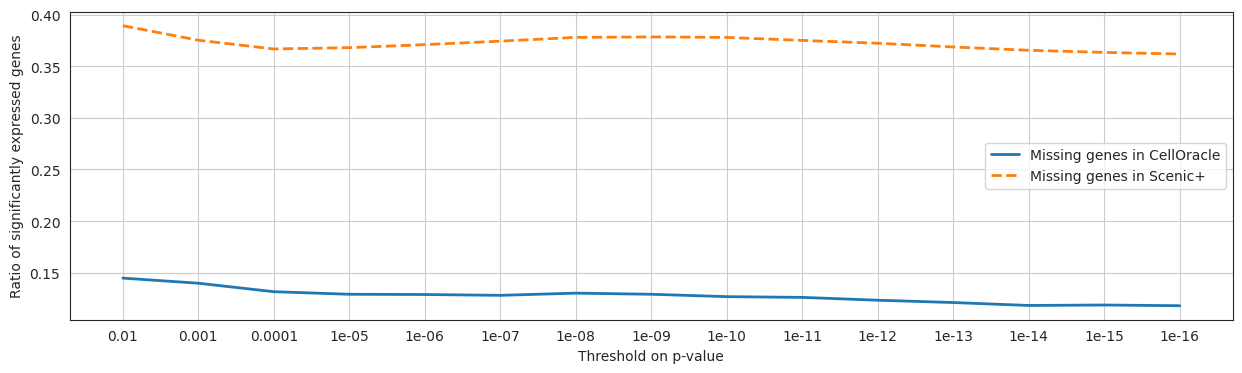

In [ ]:
# Define line styles and line width
line_styles = ['-', '--', '-.', ':'] * 2
line_width = 2  # Increase the line thickness
plt.figure(figsize=(15, 4))
# Iterate over columns and line styles
for col, style in zip(d.columns[1:], line_styles * (len(d.columns) // len(line_styles) + 1)):
    plt.plot(d[col].values, label=col, linestyle=style, linewidth=line_width)
plt.grid()
plt.legend()
plt.xticks(range(len(list_thresholds)), list_thresholds)
plt.xlabel('Threshold on p-value')
plt.ylabel('Ratio of significantly expressed genes')
plt.savefig('sig.png', bbox_inches='tight')
plt.show()

In [ ]:
d = pd.DataFrame(); IX = -1
list_thresholds = [1e-2,1e-3,1e-4,1e-5,1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12,1e-13,1e-14,1e-15,1e-16]


def calculate_percentage(t, df, filter=False):
    if filter:
        v  = df[filter_mask_de].values.ravel()
    else:
        v  = df.values.ravel()
    v = v[~np.isnan(v)]
    v = 10**(-np.abs(v))
    m = v < t
    if len(v)==0:
        raise ValueError('shouldnt be')
    return 100*m.sum()/len(v)
for t in list_thresholds:
    IX+=1
    d.loc[IX, 'Threshold'] = t
    # basics 
    df = data_df.loc[:, ~housekeeping_genes_filter]
    rr = calculate_percentage(t, df, True)
    d.loc[IX, 'Other genes'] = rr

    df = data_df.loc[:, housekeeping_genes_filter]
    rr = calculate_percentage(t, df, True)
    d.loc[IX, 'House keeping genes'] = rr

    # CO
    df = data_df.loc[:, missing_genes_co_de]
    rr = calculate_percentage(t, df, True)
    d.loc[IX, 'Missing genes in CellOracle'] = rr
    # scenic+
    df = data_df.loc[:, missing_genes_scenic_de]
    rr = calculate_percentage(t, df, True)
    d.loc[IX, 'Missing genes in Scenic+'] = rr

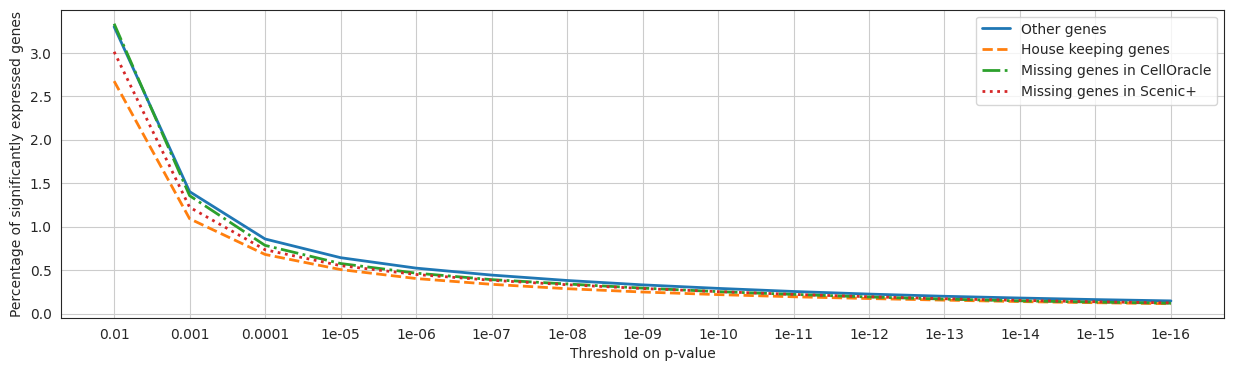

In [ ]:
# Define line styles and line width
line_styles = ['-', '--', '-.', ':'] * 2
line_width = 2  # Increase the line thickness
plt.figure(figsize=(15, 4))
# Iterate over columns and line styles
for col, style in zip(d.columns[1:], line_styles * (len(d.columns) // len(line_styles) + 1)):
    plt.plot(d[col].values, label=col, linestyle=style, linewidth=line_width)
plt.grid()
plt.legend()
plt.xticks(range(len(list_thresholds)), list_thresholds)
plt.xlabel('Threshold on p-value')
plt.ylabel('Percentage of significantly expressed genes')
plt.savefig('sig.png', bbox_inches='tight')
plt.show()